# Database population Script

## Populating the DB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ta.momentum
import ta.trend
import yfinance as yf
import sklearn as sk
import sklearn.preprocessing
import os
import sys
import time
from IPython.display import clear_output

In [2]:
NUM_TICKERS = 50
# Get the data for the top companies in the S&P 500
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
table = data[0]
# Get the top 50 companies and assigning them a unique id
tickers = {table.index[i]: table['Symbol'][i] for i in range(NUM_TICKERS)}

In [3]:
# Download the data for each company
data_pds = {}

# if data.csv does not exist, download the data
if not os.path.exists("data.csv"):
    print("Downloading data...")
    for ticker_id, ticker in tickers.items():
        clear_output(wait=True)
        sys.stdout.write(f"\rDownloading data for {ticker} ({ticker_id + 1}/{NUM_TICKERS})")
        time.sleep(0.1)
        data = yf.download(ticker, progress=False)
        data = data.reset_index()
        data.columns = data.columns.droplevel(1)
        data = data.rename_axis("Index")

        # Add the ticker ID to the data
        data["Ticker_ID"] = ticker_id

        # turning raw date into year, month, day columns
        data['Year'] = data['Date'].dt.year
        data['Month'] = data['Date'].dt.month
        data['Day'] = data['Date'].dt.day

        close_data = data['Close'].squeeze()
        data['SMA_20'] = ta.trend.sma_indicator(close_data, window=20) # 20 day simple moving average
        data['RSI_14'] = ta.momentum.rsi(close_data, window=14) # 14 day RSI

        bbands = ta.volatility.BollingerBands(close_data, window=20) # 20 day Bollinger Bands
        data["BB_Upper"] = bbands.bollinger_hband() # upper band
        data["BB_Middle"] = bbands.bollinger_mavg() # middle band
        data["BB_Lower"] = bbands.bollinger_lband() # lower band

        macd = ta.trend.MACD(close_data) # MACD
        data["MACD"] = macd.macd() # MACD line
        data["Signal"] = macd.macd_signal() # Signal line

        data["ATR"] = ta.volatility.average_true_range(data['High'].squeeze(), data['Low'].squeeze(), close_data, window=14) # 14 day ATR

        data_pds[ticker] = data.dropna()

    # combine the data
    data = pd.concat(data_pds.values())

    # looking at the future change; 1 if the price goes up, 0 if the price goes down
    data['Future_Change'] = data.groupby('Ticker_ID')['Close'].shift(-1)
    data['Future_Change'] = (data['Future_Change'] > data['Close']).astype(int)

    data.to_csv("data.csv")
else:
    print("Data already downloaded.")

In [4]:
data = pd.read_csv("data.csv")
data.drop(columns=["Index"], inplace=True)
data

,Date,Adj Close,Close,High,Low,Open,Volume,Ticker_ID,Year,Month,Day,SMA_20,RSI_14,BB_Upper,BB_Middle,BB_Lower,MACD,Signal,ATR,Future_Change
0,1962-02-16,0.565821,3.462061,3.514319,3.448997,0.000000,218150,0,1962,2,16,3.485904,46.915964,3.744046,3.485904,3.227761,0.028572,0.045884,0.069664,0
1,1962-02-19,0.557897,3.403271,3.435932,3.403271,0.000000,197101,0,1962,2,19,3.488843,41.161906,3.741763,3.488843,3.235923,0.017296,0.040167,0.068888,1
2,1962-02-20,0.580384,3.540447,3.540447,3.416336,0.000000,174138,0,1962,2,20,3.499295,55.023154,3.742415,3.499295,3.256174,0.019207,0.035975,0.073765,0
3,1962-02-21,0.578243,3.527383,3.546980,3.501254,0.000000,126298,0,1962,2,21,3.507786,53.725077,3.742219,3.507786,3.273354,0.019443,0.032668,0.071763,0
4,1962-02-23,0.572889,3.494722,3.527383,3.488190,0.000000,124384,0,1962,2,23,3.515625,50.516366,3.736934,3.515625,3.294316,0.016801,0.029495,0.069436,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418476,2024-11-21,315.410004,315.410004,317.450012,308.250000,310.000000,1602100,49,2024,11,21,299.364001,68.013756,320.177329,299.364001,278.550674,7.400162,7.295065,6.580476,1
418477,2024-11-22,321.269989,321.269989,321.899994,315.040009,315.959991,1905300,49,2024,11,22,301.125500,71.317347,323.062952,301.125500,279.188049,8.151732,7.466399,6.600441,0
418478,2024-11-25,319.390015,319.390015,326.619995,318.690002,324.529999,2967000,49,2024,11,25,302.769002,68.860199,325.006396,302.769002,280.531608,8.497702,7.672659,6.695409,0
418479,2024-11-26,317.959991,317.959991,320.989990,316.540009,320.790009,2519900,49,2024,11,26,304.184001,66.970065,326.506117,304.184001,281.861885,8.557846,7.849697,6.535021,0


In [14]:
# split the data into training and testing data
train_data = data[data['Year'] < 2018]
X_train = train_data[data.columns.drop(['Date', 'Future_Change'])].copy()
y_train = train_data['Future_Change']

test_data = data[data['Year'] >= 2018]
X_test = test_data[data.columns.drop(['Date', 'Future_Change'])].copy()
y_test = test_data['Future_Change']

print(max(data[data['Ticker_ID']==0]['Volume']))

60436750


Text(0, 0.5, 'Stock Price ($)')

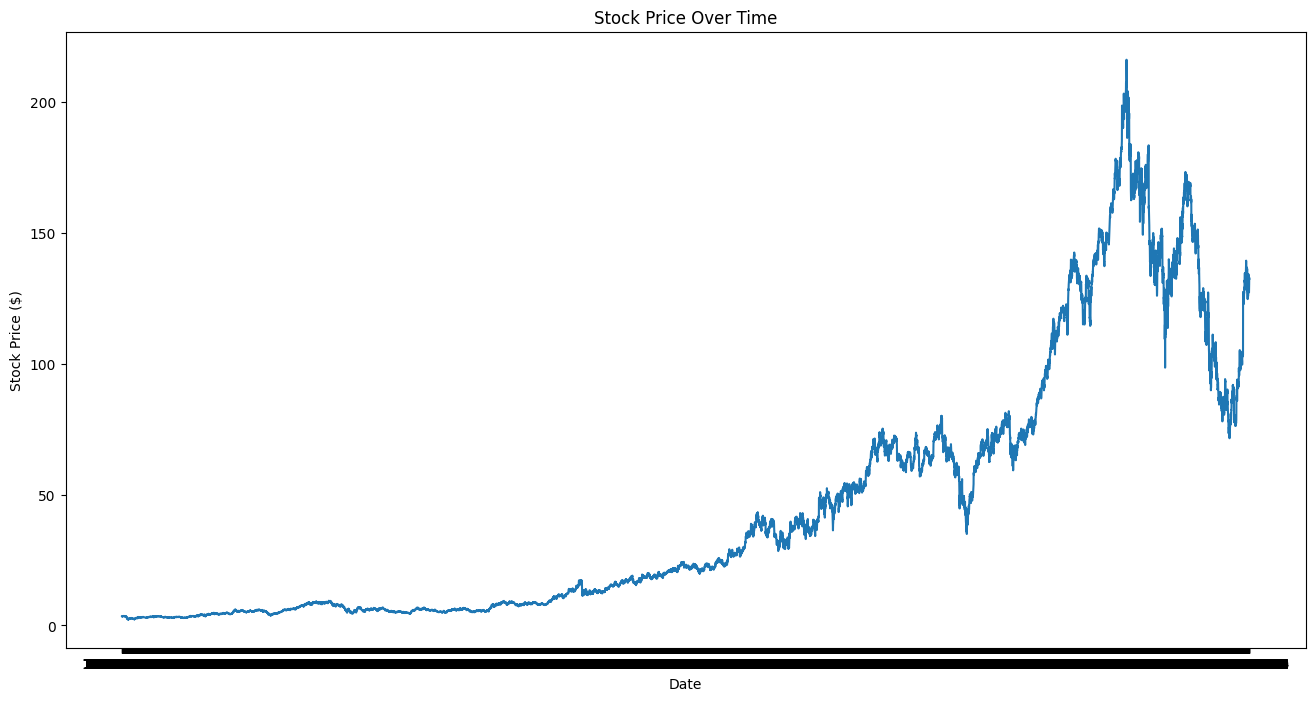

In [18]:
#visualize the data by plotting the stock price over time
plt.figure(figsize=(16, 8))
plt.plot(data[data['Ticker_ID'] == 0]['Date'], data[data['Ticker_ID'] == 0]['Close'])
plt.title("Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")

Text(0, 0.5, 'Volume')

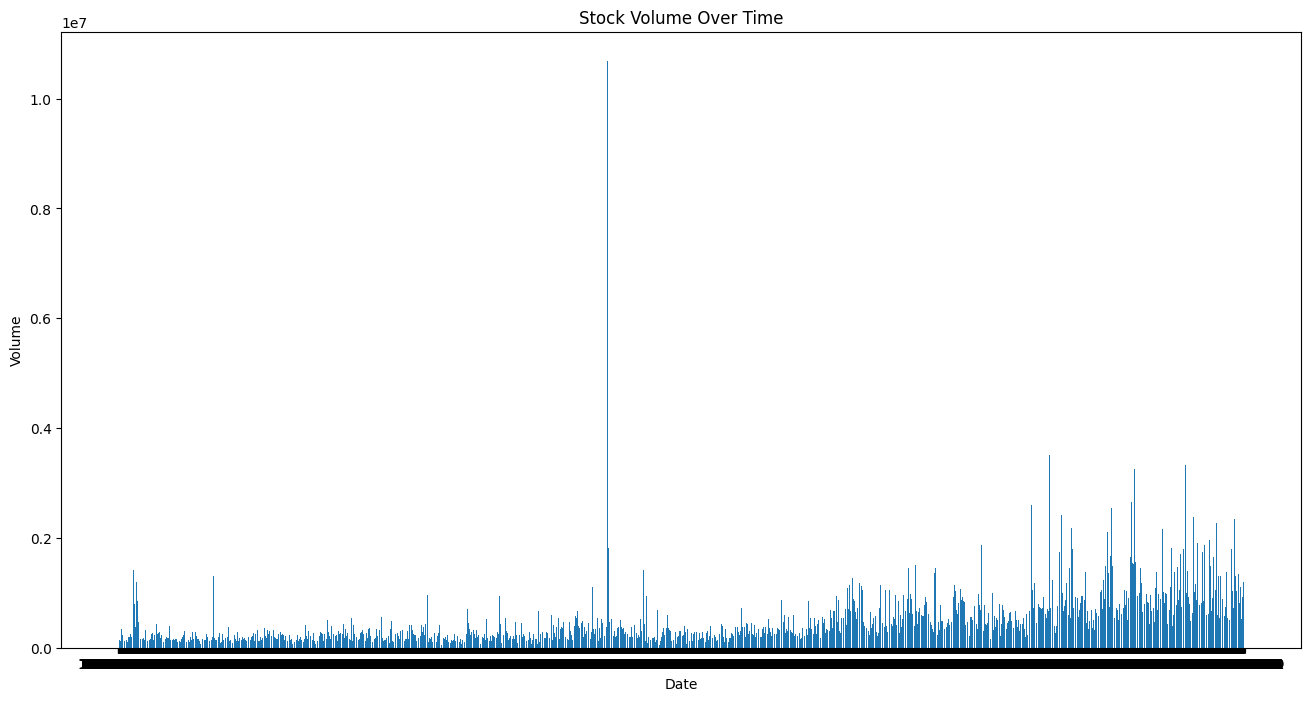

In [ ]:
#Plot the volume of a stock over time only did 5000 because it takes forever
plt.figure(figsize=(16, 8))
plt.bar(data[data['Ticker_ID'] == 0]['Date'][:5000], data[data['Ticker_ID'] == 0]['Volume'][:5000])
plt.title("Stock Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume (in 10 millions)")

In [ ]:
# normalize the training data and apply the same normalization to the testing data
scaler = sk.preprocessing.MinMaxScaler()
columns_to_normalize = X_train.columns.drop(['Ticker_ID', 'Year', 'Month', 'Day'])
X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])
X_train

In [6]:
#Create a KNN model that will classify the future change
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# predict the future change
y_pred = knn.predict(X_test)
y_pred







array([1, 1, 1, ..., 1, 1, 1])